In [1]:
import pandas as pd
import numpy as np
from scipy.io import arff
from scipy.stats import iqr

import os
import math

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

import datetime
import calendar

from numpy import mean
from numpy import std

from sklearn.preprocessing import normalize
from sklearn.preprocessing import scale
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import StratifiedKFold

import joblib

In [2]:
diab = pd.read_csv('diabetes_data_upload.csv')
print(diab.shape)
diab.head(2)

(520, 17)


,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,40,Male,No,Yes,No,Yes,No,No,No,Yes,No,Yes,No,Yes,Yes,Yes,Positive
1,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive


In [3]:
def print_unique(df):
    for col in df.columns:
        print(col, '\n', df[col].sort_values().unique(), '\n')
        
print_unique(diab)

Age 
 [16 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 72
 79 85 90] 

Gender 
 ['Female' 'Male'] 

Polyuria 
 ['No' 'Yes'] 

Polydipsia 
 ['No' 'Yes'] 

sudden weight loss 
 ['No' 'Yes'] 

weakness 
 ['No' 'Yes'] 

Polyphagia 
 ['No' 'Yes'] 

Genital thrush 
 ['No' 'Yes'] 

visual blurring 
 ['No' 'Yes'] 

Itching 
 ['No' 'Yes'] 

Irritability 
 ['No' 'Yes'] 

delayed healing 
 ['No' 'Yes'] 

partial paresis 
 ['No' 'Yes'] 

muscle stiffness 
 ['No' 'Yes'] 

Alopecia 
 ['No' 'Yes'] 

Obesity 
 ['No' 'Yes'] 

class 
 ['Negative' 'Positive'] 



In [4]:
def get_snapshot(df):
    n_missing = pd.DataFrame(df.isnull().sum(), columns = ['n_missing'])
    pct_missing = pd.DataFrame(round(df.isnull().sum() / df.shape[0], 2), columns = ['pct_missing'])
    dtype = pd.DataFrame(df.dtypes, columns = ['dtype'])
    n_unique = []
    for col in df.columns:
        n_unique.append(df[col].nunique())    
    return pd.DataFrame(n_unique, index = df.columns, columns = ['n_unique']).join(dtype).join(n_missing).join(pct_missing)

In [5]:
snapshot = get_snapshot(diab)
snapshot

,n_unique,dtype,n_missing,pct_missing
Age,51,int64,0,0.0
Gender,2,object,0,0.0
Polyuria,2,object,0,0.0
Polydipsia,2,object,0,0.0
sudden weight loss,2,object,0,0.0
weakness,2,object,0,0.0
Polyphagia,2,object,0,0.0
Genital thrush,2,object,0,0.0
visual blurring,2,object,0,0.0
Itching,2,object,0,0.0


In [6]:
bina = snapshot.index.drop(['Age', 'class'])

In [7]:
def plot_single_categorical(df, col):
    plt.figure(figsize = (4, 4))
    plt.bar(x = df[col].value_counts().index, height = df[col].value_counts(), color = mcolors.TABLEAU_COLORS)
    sns.despine(top = True)
    n_level = df[col].nunique()
    for x_coor in range(n_level):
        plt.annotate(df[col].value_counts().iloc[x_coor], 
                     xy = (x_coor, 
                           df[col].value_counts().iloc[x_coor] + df[col].value_counts().iloc[0]/50))
    plt.xticks(rotation = 0)
    plt.grid()
    plt.title(col)
    plt.show()

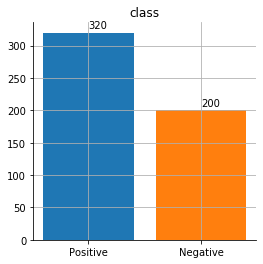

In [8]:
plot_single_categorical(diab, 'class')

In [9]:
enc = OrdinalEncoder(dtype = int)

In [10]:
X = pd.DataFrame(enc.fit_transform(diab[bina]), columns = bina).join(diab['Age'])

In [11]:
enc_y = LabelEncoder()
y = enc_y.fit_transform(diab['class'])

In [20]:
def feat_significance(X, y, n_feat_data_type, num):
    mi_df = pd.DataFrame(mutual_info_classif(X, y, random_state = 42), index = X.columns, columns = ['score'])
    mi_df = mi_df.sort_values(by = 'score', ascending = False)
    
    def color_cell(s):    
        background = []
        for i in range(len(s.index)):
            if s.index[i] in num:
                background.append('background-color: yellow')
            else:
                background.append('')
        return background
    
    if n_feat_data_type == 1:
        return mi_df
    else:
        return mi_df.style.apply(color_cell, axis = 0)

In [22]:
feat_score = feat_significance(X, y, 2, 'Age')
feat_score

,score
Polyuria,0.250708
Polydipsia,0.247022
Age,0.122378
Gender,0.117260
sudden weight loss,0.105781
partial paresis,0.091547
muscle stiffness,0.065289
Irritability,0.063798
visual blurring,0.034429
Alopecia,0.028893


In [23]:
def get_mean_std(df):
    mean_col = pd.DataFrame(df.mean(), columns = ['mean'])
    std_col = pd.DataFrame(df.std(), columns = ['std'])
    mean_plus_std = mean_col.join(std_col)
    return mean_plus_std

In [24]:
get_mean_std(X)

,mean,std
Gender,0.630769,0.483061
Polyuria,0.496154,0.500467
Polydipsia,0.448077,0.497776
sudden weight loss,0.417308,0.493589
weakness,0.586538,0.492928
Polyphagia,0.455769,0.498519
Genital thrush,0.223077,0.416710
visual blurring,0.448077,0.497776
Itching,0.486538,0.500300
Irritability,0.242308,0.428892


In [25]:
X_scaled = pd.DataFrame(scale(X), columns = X.columns)

In [26]:
lr = LogisticRegression(random_state = 42)
knn = KNeighborsClassifier()
svc = SVC(random_state = 42)
tree = DecisionTreeClassifier(max_features = 'auto', random_state = 42)

In [27]:
alg_dict = {lr: 'lr', svc: 'svc', knn: 'knn', tree: 'tree'}

In [28]:
def num_feat_perform(algorithm, feat_ordered, X_ordered, y, metric):
    scores = []
    for i in range(1, len(feat_ordered)+1):
        pred_data = X_ordered.iloc[:, 0:i]
        score = mean(cross_val_score(algorithm, pred_data, y, scoring = metric, cv = 5))
        scores.append(score)

    n_features = len(feat_ordered)
    plt.plot(np.arange(n_features), scores, marker = 'x')
    plt.xticks(np.arange(n_features), np.arange(1, n_features + 1))
    for i in range(n_features):
        plt.text(i, scores[i], s = round(scores[i], 2))
    plt.grid()
    plt.xlabel('no. of features')
    plt.ylabel('score')
    
def num_feat_multi_alg(alg_dict, feat_ordered, X_ordered, y, metric):
    n_algorithm = len(alg_dict)
    algorithms = list(alg_dict.keys())
    alg_names = list(alg_dict.values())
    if n_algorithm <= 2:
        nrows = 1
        ncols = n_algorithm
        fig = plt.figure(figsize = (ncols * 6, 4))
    else:
        nrows = math.ceil(n_algorithm / 2)
        ncols = 2
        fig = plt.figure(figsize = (12, nrows * 4))

    for n in range(n_algorithm):
        ax = fig.add_subplot(nrows, ncols, n + 1)
        ax = num_feat_perform(algorithms[n], feat_ordered, X_ordered, y, metric)
        plt.title(f"'{alg_names[n]}' performance by '{metric}'")
        
    plt.tight_layout()
    plt.show()

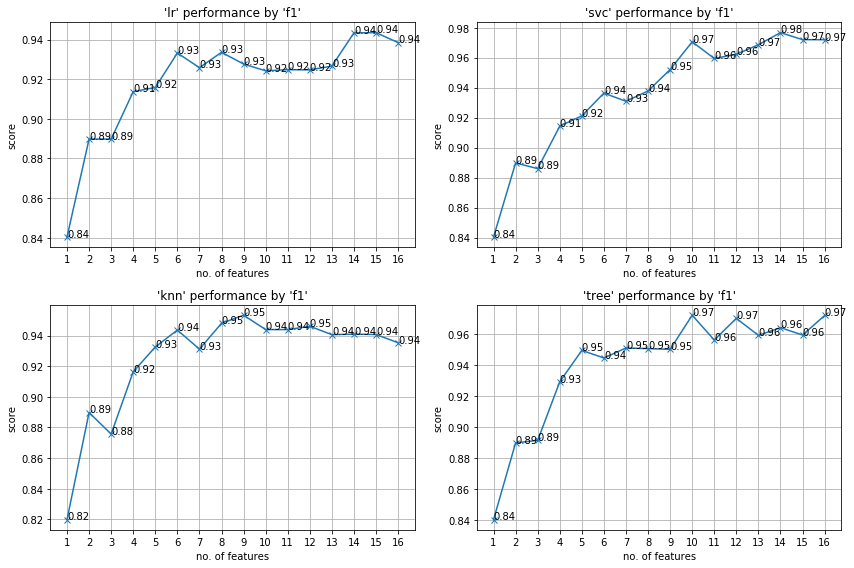

In [29]:
num_feat_multi_alg(alg_dict, feat_score.index, X_scaled[feat_score.index], y, 'f1')

In [30]:
feat_to_be_dropped = []
for index in [2, 6, 10, 14, 15]:
    feat_to_be_dropped.append(feat_score.index[index])
    
feat_svc = feat_score.index.drop(feat_to_be_dropped)
feat_svc

Index(['Polyuria', 'Polydipsia', 'Gender', 'sudden weight loss',
       'partial paresis', 'Irritability', 'visual blurring', 'Alopecia',
       'Obesity', 'Genital thrush', 'Itching'],
      dtype='object')

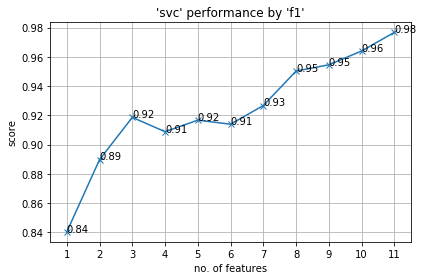

In [31]:
num_feat_multi_alg({svc: 'svc'}, feat_svc, X_scaled[feat_svc], y, 'f1')

In [32]:
def plot_learning_curve(train_scores, test_scores, train_sizes):
    train_scores = pd.DataFrame(train_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    train_scores = train_scores.join(pd.Series(train_scores.mean(axis = 1), name = 'mean'))

    test_scores = pd.DataFrame(test_scores, index = train_sizes, columns = ['split1', 'split2', 'split3', 'split4', 'split5'])
    test_scores = test_scores.join(pd.Series(test_scores.mean(axis = 1), name = 'mean'))

    plt.plot(train_scores['mean'], label = 'train_scores')
    plt.plot(test_scores['mean'], label = 'test_scores')
    plt.legend()
    plt.grid()
    plt.xlabel('no. of training samples')
    
def two_metric_graph(algorithm, X, y):
    train_sizes = np.linspace(start = 10, stop = X.shape[0] * 0.8, num = 6, dtype = int)
    fig = plt.figure(figsize = (10, 4))

    for i, metric in enumerate(['f1', 'balanced_accuracy']):
        train_sizes_abs, train_scores, test_scores = learning_curve(algorithm, X, y, train_sizes = train_sizes, 
                                                                    scoring = metric, cv = 5, shuffle = True, 
                                                                    random_state = 42)
        ax = fig.add_subplot(1, 2, i + 1)
        ax = plot_learning_curve(train_scores, test_scores, train_sizes)
        plt.title(f"'performance by '{metric}'")

    plt.tight_layout()
    plt.show()

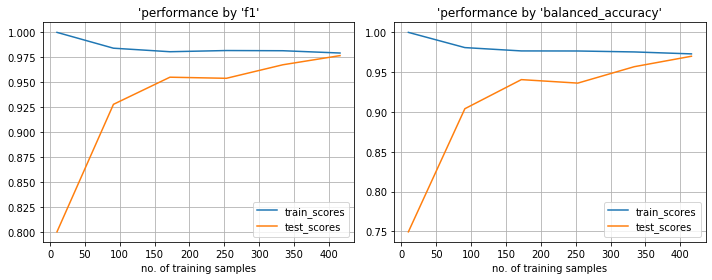

In [33]:
two_metric_graph(svc, X_scaled[feat_svc], y)

In [34]:
feat_svc

Index(['Polyuria', 'Polydipsia', 'Gender', 'sudden weight loss',
       'partial paresis', 'Irritability', 'visual blurring', 'Alopecia',
       'Obesity', 'Genital thrush', 'Itching'],
      dtype='object')

In [35]:
len(feat_svc)

11

In [36]:
svc.fit(X_scaled[feat_svc], y)
joblib.dump(svc, 'svc.joblib')

['svc.joblib']